In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as st
from matplotlib import pyplot as plt

In [3]:
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()


def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def get_predictors(df, target):
    return [col for col in df.columns if col != target]

def extended_describe(dataframe):
    extended_describe_df = dataframe.describe(include='all').T
    extended_describe_df['null_count'] = dataframe.isnull().sum()
    extended_describe_df['unique_count'] = dataframe.apply(
        lambda x: len(x.unique()))
    return extended_describe_df

In [5]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import learning_curve
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error

def residual_plot(model,X_train, y_train,X_validation, y_validation):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
    visualizer.show()         

def prediction_error(model,X_train, y_train,X_validation, y_validation):
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
    visualizer.show()  

def show_learning_curve(model,X_train, y_train,X_validation, y_validation):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X_train, y_train.values.ravel(), cv=5)
    plot_learning_curve(train_sizes, train_scores, validation_scores)

In [6]:
target = 'Item_Outlet_Sales'

train_file = 'train.csv'
test_file = 'test.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

test_df_copy = test_df.copy()

predictors = get_predictors(train_df, target)

In [7]:
data = pd.concat([train_df, test_df], ignore_index=True)
visibility_avg = train_df.groupby(['Item_Identifier'])['Item_Visibility'].agg(pd.Series.mean)

# Impute 0 values with mean train_df of that product:
miss_bool = (train_df['Item_Visibility'] == 0)
miss_test_bool = (test_df['Item_Visibility'] == 0)

print('Number of 0 values initially: ', sum(miss_bool))
print('Number of 0 test values initially: ', sum(miss_test_bool))

train_df.loc[miss_bool, 'Item_Visibility'] = train_df.loc[
miss_bool, 'Item_Identifier'].apply(lambda x: visibility_avg.get(x, 0))
test_df.loc[miss_test_bool, 'Item_Visibility'] = test_df.loc[
    miss_test_bool,
    'Item_Identifier'].apply(lambda x: visibility_avg.get(x, 0))
print('Number of 0 values after modification: ',
      sum(train_df['Item_Visibility'] == 0))
print('Number of 0 values after modification: ',
      sum(test_df['Item_Visibility'] == 0))

item_avg_weight = data.groupby(['Item_Identifier'])[
    'Item_Weight'].agg(pd.Series.mean)

# Get a boolean variable specifying missing Item_Weight values
miss_train_bool = train_df['Item_Weight'].isnull()
miss_test_bool = test_df['Item_Weight'].isnull()

# Impute data and check #missing values before and after imputation to confirm
print('Original #missing:', sum(miss_train_bool))
print('Original #missing:', sum(miss_test_bool))

train_df.loc[miss_train_bool, 'Item_Weight'] = train_df.loc[miss_train_bool,
                                                            'Item_Identifier'].apply(lambda x: item_avg_weight.get(x, None))
test_df.loc[miss_test_bool, 'Item_Weight'] = test_df.loc[miss_test_bool,
                                                         'Item_Identifier'].apply(lambda x: item_avg_weight.get(x, None))

print('Final #missing: ', sum(train_df['Item_Weight'].isnull()))
print('Final #missing: ', sum(test_df['Item_Weight'].isnull()))

outlet_location_mode = train_df.groupby(['Outlet_Location_Type'])[
    'Outlet_Size'].agg(pd.Series.mode)

# Get a boolean variable specifying missing Item_Weight values
miss_train_bool = train_df['Outlet_Size'].isnull()
miss_test_bool = test_df['Outlet_Size'].isnull()

# Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing:', sum(miss_train_bool))
print('Orignal #missing:', sum(miss_test_bool))

train_df.loc[miss_train_bool, 'Outlet_Size'] = train_df.loc[miss_train_bool,
                                                            'Outlet_Location_Type'].apply(lambda x: outlet_location_mode.get(x, None))
test_df.loc[miss_test_bool, 'Outlet_Size'] = test_df.loc[miss_test_bool,
                                                         'Outlet_Location_Type'].apply(lambda x: outlet_location_mode.get(x, None))

print('Final #missing: ', sum(train_df['Outlet_Size'].isnull()))
print('Final #missing: ', sum(test_df['Outlet_Size'].isnull()))

Number of 0 values initially:  526
Number of 0 test values initially:  353
Number of 0 values after modification:  0
Number of 0 values after modification:  0
Original #missing: 1463
Original #missing: 976
Final #missing:  0
Final #missing:  0
Orignal #missing: 2410
Orignal #missing: 1606
Final #missing:  0
Final #missing:  0


In [8]:
replace_fc = {'LF': 'Low Fat', 'low fat': 'Low Fat', 'low fat': 'Low Fat',
              'reg': 'Regular', 'Low Fat': 'Low Fat', 'Regular': 'Regular'}

train_df['Item_Fat_Content'].value_counts()

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].map(replace_fc)
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].map(replace_fc)

In [9]:
train_df['Years'] = train_df['Outlet_Establishment_Year'].apply(
    lambda x: 2013 - x)
test_df['Years'] = test_df['Outlet_Establishment_Year'].apply(
    lambda x: 2013 - x)

In [10]:
extended_describe(train_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
Item_Identifier,8523,1559,FDG33,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1559
Item_Weight,8523.0000,NaN,NaN,NaN,12.8736,4.6459,4.5550,8.7850,12.6000,16.8500,21.3500,0,510
Item_Fat_Content,8523,2,Low Fat,5517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
Item_Visibility,8523.0000,NaN,NaN,NaN,0.0697,0.0498,0.0036,0.0311,0.0569,0.0972,0.3284,0,8325
Item_Type,8523,16,Fruits and Vegetables,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16
Item_MRP,8523.0000,NaN,NaN,NaN,140.9928,62.2751,31.2900,93.8265,143.0128,185.6437,266.8884,0,5938
Outlet_Identifier,8523,10,OUT027,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
Outlet_Establishment_Year,8523.0000,NaN,NaN,NaN,1997.8319,8.3718,1985.0000,1987.0000,1999.0000,2004.0000,2009.0000,0,9
Outlet_Size,8523,3,Small,4243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
Outlet_Location_Type,8523,3,Tier 3,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [11]:
extended_describe(test_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
Item_Identifier,5681,1543,DRF48,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1543
Item_Weight,5681.0000,NaN,NaN,NaN,12.6730,4.6583,4.5550,8.6150,12.3500,16.7000,21.3500,0,490
Item_Fat_Content,5681,2,Low Fat,3668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
Item_Visibility,5681.0000,NaN,NaN,NaN,0.0698,0.0497,0.0036,0.0312,0.0577,0.0969,0.3236,0,5596
Item_Type,5681,16,Snack Foods,789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16
Item_MRP,5681.0000,NaN,NaN,NaN,141.0233,61.8091,31.9900,94.4120,141.4154,186.0266,266.5884,0,4402
Outlet_Identifier,5681,10,OUT027,624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
Outlet_Establishment_Year,5681.0000,NaN,NaN,NaN,1997.8289,8.3723,1985.0000,1987.0000,1999.0000,2004.0000,2009.0000,0,9
Outlet_Size,5681,3,Small,2828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
Outlet_Location_Type,5681,3,Tier 3,2233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [12]:
full_data = pd.concat([train_df, test_df], ignore_index=True)

In [13]:
import featuretools as ft

es = ft.EntitySet(id='sales')

# adding a dataframe
es.entity_from_dataframe(entity_id='bigmart', dataframe=full_data, index='id')
es.normalize_entity(base_entity_id='bigmart', new_entity_id='outlet', index='Outlet_Identifier',
                    additional_variables=['Years', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'])

feature_matrix, feature_names = ft.dfs(entityset=es,
                                       target_entity='bigmart',
                                       max_depth=2,
                                       verbose=1,
                                       n_jobs=3)

2020-04-11 14:10:22,415 featuretools.entityset - WARNING    index id not found in dataframe, creating new integer column
Built 50 features
EntitySet scattered to 3 workers in 11 seconds                                                                
Elapsed: 00:02 | Progress: 100%|██████████████████████████████████████████████████████████████████████████████


In [14]:
feature_matrix = feature_matrix.reindex(index=full_data['id'])
feature_matrix = feature_matrix.reset_index()

In [15]:
feature_matrix.head()

,id,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,...,outlet.MEAN(bigmart.Outlet_Establishment_Year),outlet.MEAN(bigmart.Item_Visibility),outlet.MEAN(bigmart.Item_MRP),outlet.COUNT(bigmart),outlet.NUM_UNIQUE(bigmart.Item_Fat_Content),outlet.NUM_UNIQUE(bigmart.Item_Type),outlet.NUM_UNIQUE(bigmart.Item_Identifier),outlet.MODE(bigmart.Item_Fat_Content),outlet.MODE(bigmart.Item_Type),outlet.MODE(bigmart.Item_Identifier)
0,0,FDA15,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,3735.1380,...,1999,0.0641,141.1632,1550,2,16,1550,Low Fat,Fruits and Vegetables,DRA12
1,1,DRC01,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,443.4228,...,2009,0.0643,141.0009,1546,2,16,1546,Low Fat,Fruits and Vegetables,DRA12
2,2,FDN15,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,2097.2700,...,1999,0.0641,141.1632,1550,2,16,1550,Low Fat,Fruits and Vegetables,DRA12
3,3,FDX07,19.2000,Regular,0.0153,Fruits and Vegetables,182.0950,OUT010,1998,732.3800,...,1998,0.1052,141.1597,925,2,16,925,Low Fat,Fruits and Vegetables,DRA12
4,4,NCD19,8.9300,Low Fat,0.0081,Household,53.8614,OUT013,1987,994.7052,...,1987,0.0641,141.1284,1553,2,16,1553,Low Fat,Fruits and Vegetables,DRA12


In [16]:
cols_to_drop = [
    'id', 'outlet.MEAN(bigmart.Item_MRP)', 'outlet.Outlet_Location_Type',
    'outlet.MIN(bigmart.Item_MRP)', 'outlet.MAX(bigmart.Item_MRP)',
    'outlet.STD(bigmart.Item_Visibility)', 'outlet.MEAN(bigmart.Item_Weight)',
    'outlet.STD(bigmart.Item_Weight)', 'Item_Visibility', 'outlet.Years',
    'outlet.SKEW(bigmart.Item_Weight)', 'Item_Weight', 'Item_Fat_Content',
    'outlet.SKEW(bigmart.Item_MRP)', 'outlet.NUM_UNIQUE(bigmart.Item_Type)',
    'outlet.NUM_UNIQUE(bigmart.Item_Fat_Content)',
    'outlet.MODE(bigmart.Item_Fat_Content)', 'outlet.MIN(bigmart.Item_Weight)',
    'outlet.MAX(bigmart.Item_Weight)', 'outlet.MIN(bigmart.Item_Outlet_Sales)',
    'outlet.NUM_UNIQUE(bigmart.Item_Type)',
    'outlet.NUM_UNIQUE(bigmart.Item_Fat_Content)',
    'outlet.MODE(bigmart.Item_Type)', 'outlet.MODE(bigmart.Item_Fat_Content)',
    'outlet.SUM(bigmart.Item_Weight)', 'outlet.SUM(bigmart.Item_Outlet_Sales)',
    'outlet.STD(bigmart.Item_Outlet_Sales)',
    'outlet.MAX(bigmart.Item_Outlet_Sales)',
    'outlet.SKEW(bigmart.Item_Outlet_Sales)',
    'outlet.MIN(bigmart.Item_Outlet_Sales)',
    'outlet.MEAN(bigmart.Item_Outlet_Sales)'
]

In [17]:
feature_matrix.drop(cols_to_drop, axis=1, inplace=True)
train_df = feature_matrix[:8523]
test_df = feature_matrix[8523:]

In [18]:
train_df.head()

,Item_Identifier,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,outlet.Outlet_Size,outlet.Outlet_Type,outlet.SUM(bigmart.Outlet_Establishment_Year),outlet.SUM(bigmart.Item_Visibility),...,outlet.MAX(bigmart.Item_Visibility),outlet.SKEW(bigmart.Outlet_Establishment_Year),outlet.SKEW(bigmart.Item_Visibility),outlet.MIN(bigmart.Outlet_Establishment_Year),outlet.MIN(bigmart.Item_Visibility),outlet.MEAN(bigmart.Outlet_Establishment_Year),outlet.MEAN(bigmart.Item_Visibility),outlet.COUNT(bigmart),outlet.NUM_UNIQUE(bigmart.Item_Identifier),outlet.MODE(bigmart.Item_Identifier)
0,FDA15,Dairy,249.8092,OUT049,1999,3735.1380,Medium,Supermarket Type1,3098450,99.4015,...,0.1879,0,0.8086,1999,0.0036,1999,0.0641,1550,1550,DRA12
1,DRC01,Soft Drinks,48.2692,OUT018,2009,443.4228,Medium,Supermarket Type2,3105914,99.4639,...,0.1978,0,0.8434,2009,0.0036,2009,0.0643,1546,1546,DRA12
2,FDN15,Meat,141.6180,OUT049,1999,2097.2700,Medium,Supermarket Type1,3098450,99.4015,...,0.1879,0,0.8086,1999,0.0036,1999,0.0641,1550,1550,DRA12
3,FDX07,Fruits and Vegetables,182.0950,OUT010,1998,732.3800,Medium,Grocery Store,1848150,97.2815,...,0.3139,0,0.8643,1998,0.0060,1998,0.1052,925,925,DRA12
4,NCD19,Household,53.8614,OUT013,1987,994.7052,High,Supermarket Type1,3085811,99.4727,...,0.1924,0,0.8255,1987,0.0036,1987,0.0641,1553,1553,DRA12


In [19]:
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

cat_columns  =  [ col for col in train_df.select_dtypes(include='object').columns if col not in ['Item_Identifier','Outlet_Identifier']]

ohe_enc = OneHotCategoricalEncoder( variables=cat_columns, drop_last=False)

data_df = pd.concat([train_df, test_df], ignore_index=True)

ohe_enc.fit(data_df)

data_df = ohe_enc.transform(data_df)

train_df = data_df[data_df['Item_Outlet_Sales'].notnull()]

test_df = data_df[data_df['Item_Outlet_Sales'].isnull()]

In [20]:
test_df.head()

,Item_Identifier,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Item_Outlet_Sales,outlet.SUM(bigmart.Outlet_Establishment_Year),outlet.SUM(bigmart.Item_Visibility),outlet.SUM(bigmart.Item_MRP),outlet.STD(bigmart.Outlet_Establishment_Year),outlet.STD(bigmart.Item_MRP),...,Item_Type_Seafood,outlet.Outlet_Size_Medium,outlet.Outlet_Size_High,outlet.Outlet_Size_Small,outlet.Outlet_Type_Supermarket Type1,outlet.Outlet_Type_Supermarket Type2,outlet.Outlet_Type_Grocery Store,outlet.Outlet_Type_Supermarket Type3,outlet.MODE(bigmart.Item_Identifier)_DRA12,outlet.MODE(bigmart.Item_Identifier)_DRA24
8523,FDW58,107.8622,OUT049,1999,nan,3098450,99.4015,218802.9588,0.0000,62.1446,...,0,1,0,0,1,0,0,0,1,0
8524,FDW14,87.3198,OUT017,2007,nan,3096801,99.5708,217561.3500,0.0000,62.2955,...,0,0,0,1,1,0,0,0,1,0
8525,NCN55,241.7538,OUT010,1998,nan,1848150,97.2815,130572.7618,0.0000,62.0108,...,0,1,0,0,0,0,1,0,1,0
8526,FDQ58,155.0340,OUT017,2007,nan,3096801,99.5708,217561.3500,0.0000,62.2955,...,0,0,0,1,1,0,0,0,1,0
8527,FDY38,234.2300,OUT027,1985,nan,3094615,99.3590,219838.2488,0.0000,62.0597,...,0,1,0,0,0,0,0,1,1,0


In [21]:
#train_df['Item_Outlet_Sales'] = np.sqrt(train_df['Item_Outlet_Sales'])

In [22]:
drop_cols=['Outlet_Establishment_Year','Item_Identifier','Outlet_Identifier','Item_Identifier']

In [23]:
train_df.drop(drop_cols,axis=1,inplace=True)
test_df.drop(drop_cols,axis=1,inplace=True)

In [24]:
test_df.drop(['Item_Outlet_Sales'],axis=1,inplace=True)

In [25]:
X = train_df.drop(['Item_Outlet_Sales'], axis=1)
y = train_df['Item_Outlet_Sales']
X_test = test_df

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [27]:
test_df.head()

,Item_MRP,outlet.SUM(bigmart.Outlet_Establishment_Year),outlet.SUM(bigmart.Item_Visibility),outlet.SUM(bigmart.Item_MRP),outlet.STD(bigmart.Outlet_Establishment_Year),outlet.STD(bigmart.Item_MRP),outlet.MAX(bigmart.Outlet_Establishment_Year),outlet.MAX(bigmart.Item_Visibility),outlet.SKEW(bigmart.Outlet_Establishment_Year),outlet.SKEW(bigmart.Item_Visibility),...,Item_Type_Seafood,outlet.Outlet_Size_Medium,outlet.Outlet_Size_High,outlet.Outlet_Size_Small,outlet.Outlet_Type_Supermarket Type1,outlet.Outlet_Type_Supermarket Type2,outlet.Outlet_Type_Grocery Store,outlet.Outlet_Type_Supermarket Type3,outlet.MODE(bigmart.Item_Identifier)_DRA12,outlet.MODE(bigmart.Item_Identifier)_DRA24
8523,107.8622,3098450,99.4015,218802.9588,0.0000,62.1446,1999,0.1879,0,0.8086,...,0,1,0,0,1,0,0,0,1,0
8524,87.3198,3096801,99.5708,217561.3500,0.0000,62.2955,2007,0.1886,0,0.8188,...,0,0,0,1,1,0,0,0,1,0
8525,241.7538,1848150,97.2815,130572.7618,0.0000,62.0108,1998,0.3139,0,0.8643,...,0,1,0,0,0,0,1,0,1,0
8526,155.0340,3096801,99.5708,217561.3500,0.0000,62.2955,2007,0.1886,0,0.8188,...,0,0,0,1,1,0,0,0,1,0
8527,234.2300,3094615,99.3590,219838.2488,0.0000,62.0597,1985,0.1867,0,0.8323,...,0,1,0,0,0,0,0,1,1,0


In [28]:
from xgboost.sklearn import XGBRegressor 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [29]:
xg_reg = XGBRegressor(objective ='reg:squarederror',learning_rate = 0.01, max_depth = 5, 
                          alpha = 4, n_estimators = 200)

In [30]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [31]:
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
n_folds = 5

def rmsle_cv(model,train,y_train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def best_fit_search(grid, train_X, train_y,plot_learning_curve=False):

    grid.fit(X=train_X, y=train_y)
    print(grid.best_score_)
    print(grid.best_params_)
    best_model = grid.best_estimator_
    best_model.fit(X=X_trainmodel, y=y_trainmodel)
    y_pred_val = best_model.predict(X=X_val)
    
    if plot_learning_curve:
        train_sizes, train_scores, validation_scores = learning_curve(best_model,
                                                                  X_trainmodel, y_trainmodel.values.ravel(), cv=5)
        plot_learning_curve(train_sizes, train_scores, validation_scores)
    return best_model


In [32]:
def modelfit(alg, X_train,y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:    
        xgb_param = alg.get_xgb_params()    
        xgtrain = xgb.DMatrix(X_train, label=y_train,feature_names = list(X_train.columns))    
        cvresult = xgb.cv(xgb_param, xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,metrics='rmse',
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])        

#Fit the algorithm on the data    
    alg.fit(X_train, y_train,eval_metric='rmse')            

    #Predict training set:    
    dtrain_predictions = alg.predict(X_train)
  

    #Print model report:    
    print ("\nModel Report" )  
    print(cvresult)
    return alg


In [33]:
params = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'min_child_weight': 0.8,
    'eta':.3,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
     'eval_metric':'rmse',
    'objective' :'reg:squarederror'
 
}

In [34]:
dtrain = xgb.DMatrix(X_train.values, label=y_train.values,feature_names=list(X_train.columns))
dval =  xgb.DMatrix(X_validation.values, label=y_validation.values,feature_names=list(X_validation.columns))
dtest = xgb.DMatrix(X_test.values, feature_names=list(X_test.columns))

In [35]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10
)

[0]	Validation-rmse:2109.86
Will train until Validation-rmse hasn't improved in 10 rounds.
[1]	Validation-rmse:1777.98
[2]	Validation-rmse:1592.8
[3]	Validation-rmse:1333.39
[4]	Validation-rmse:1280.02
[5]	Validation-rmse:1163.06
[6]	Validation-rmse:1102.8
[7]	Validation-rmse:1069.06
[8]	Validation-rmse:1066.35
[9]	Validation-rmse:1050.79
[10]	Validation-rmse:1045.38
[11]	Validation-rmse:1045.24
[12]	Validation-rmse:1048.64
[13]	Validation-rmse:1049.93
[14]	Validation-rmse:1049.7
[15]	Validation-rmse:1054.37
[16]	Validation-rmse:1054.54
[17]	Validation-rmse:1055.33
[18]	Validation-rmse:1054.85
[19]	Validation-rmse:1054.89
[20]	Validation-rmse:1055.16
[21]	Validation-rmse:1057.31
Stopping. Best iteration:
[11]	Validation-rmse:1045.24



In [36]:
xg_reg = XGBRegressor(**params)
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.3,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=0.8, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [37]:
Check

NameError: name 'Check' is not defined

In [39]:
alg= modelfit(xg_reg, X_train,y_train)


Model Report
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         2599.5103          8.1966       2599.9891        39.1906
1         2421.3929         11.7170       2423.6878        52.3514
2         2238.2225          6.5511       2243.6333        35.9815
3         2093.1116         20.8809       2100.6807        37.1333
4         1950.0308         27.9249       1962.0490        46.7124
5         1815.3828         24.3310       1832.0276        43.1109
6         1724.2060         33.3315       1742.2555        45.8141
7         1631.4747         37.3415       1654.0783        53.8278
8         1563.7724         44.5663       1589.4244        59.5330
9         1490.4281         37.1734       1519.6624        45.3827
10        1422.7335         46.1166       1457.9138        53.2940
11        1362.2292         43.7433       1402.7423        44.9737
12        1323.2380         41.3616       1366.9390        46.8718
13        1275.8442         34.0600       1324.7

In [40]:
def get_best_estimator(model,model_params,X_train,y_train,scoring='r2'):
    gsearch = GridSearchCV(estimator = model,param_grid = model_params, scoring=scoring,n_jobs=4,iid=False, cv=5) 
    gsearch.fit(X_train,y_train) 
    prediction_error(gsearch.best_estimator_,X_train, y_train,X_validation, y_validation)
    return gsearch.best_estimator_

In [41]:
xgb1 = XGBRegressor(**params, nthread=4, scale_pos_weight=1, seed=27)
xgb1 =modelfit(xgb1, X_train,y_train)


Model Report
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         2560.1937          9.0153       2562.7938        36.2318
1         2358.7250         17.5778       2363.3513        33.5918
2         2181.0979         15.9045       2190.0875        36.5183
3         2036.5860         26.2268       2048.1072        43.9855
4         1891.1855         23.3319       1907.5208        40.8592
5         1773.6625         27.7307       1792.9107        31.2451
6         1677.5224         35.4347       1700.3405        37.3365
7         1583.5030         36.9825       1610.5059        41.2670
8         1508.9472         35.7002       1539.0801        38.0860
9         1446.2658         41.6849       1479.9088        40.2852
10        1384.0408         47.4261       1422.6789        38.8272
11        1330.4364         38.0901       1373.4590        34.2535
12        1291.5057         43.7300       1338.5576        35.1106
13        1263.0161         45.1340       1312.0

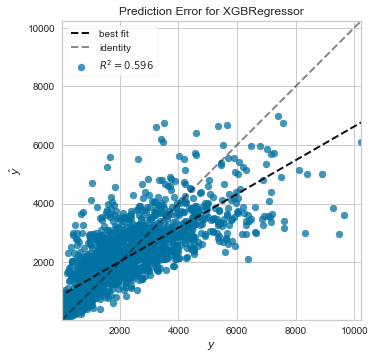

In [42]:
prediction_error(xgb1,X_train, y_train,X_validation, y_validation)

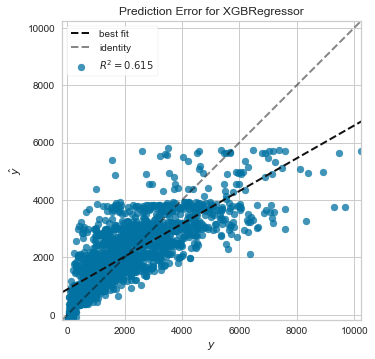

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.3,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=17, missing=None, n_estimators=37, n_jobs=1,
             nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.7, verbosity=1)


In [57]:
param_test1 = { 'max_depth':[2,3,6,8,10], 'min_child_weight':range(5,20,3) }
best_estimator = get_best_estimator(xgb1,param_test1,X_train,y_train)
print(best_estimator)

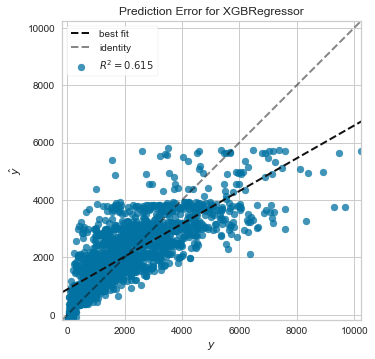

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.3,
             eval_metric='rmse', gamma=0.0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=17, missing=None, n_estimators=37, n_jobs=1,
             nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.7, verbosity=1)


In [44]:
param_test3 = { 'gamma':[i/10.0 for i in range(0,5)] }
best_estimator = get_best_estimator(best_estimator,param_test3,X_train,y_train)
print(best_estimator)

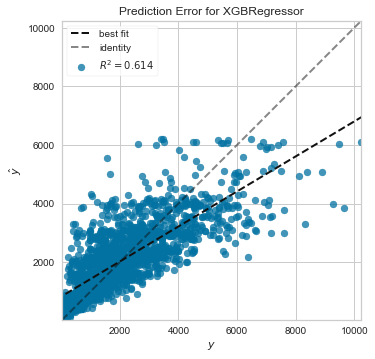

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.3,
             eval_metric='rmse', gamma=0.0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=17, missing=None, n_estimators=37, n_jobs=1,
             nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.6, verbosity=1)


In [45]:
param_test4 = { 'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)] }
best_estimator = get_best_estimator(best_estimator,param_test4,X_train,y_train)
print(best_estimator)

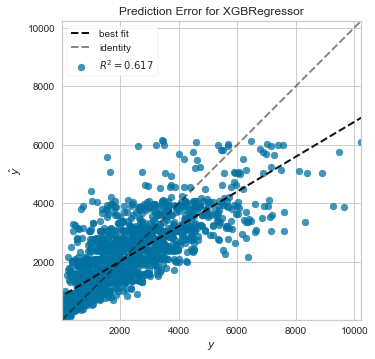

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.3,
             eval_metric='rmse', gamma=0.0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=17, missing=None, n_estimators=37, n_jobs=1,
             nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.8, verbosity=1)


In [46]:
param_test5 = { 'subsample':[i/100.0 for i in range(75,90,5)], 'colsample_bytree':[0.9] }
best_estimator = get_best_estimator(best_estimator,param_test5,X_train,y_train)
print(best_estimator)

In [ ]:
# param_test7 = { 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05] }
# best_estimator = get_best_estimator(best_estimator,param_test7,X_train,y_train)
# print(best_estimator)

In [47]:
alg= modelfit(best_estimator, X_train,y_train)


Model Report
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         2567.7876          8.5481       2568.2589        38.3008
1         2367.7740          7.6288       2367.9508        37.3119
2         2191.6315          6.4407       2192.7745        36.4795
3         2049.2407          9.5183       2051.0129        41.6957
4         1912.4965          7.8897       1915.5699        40.1068
5         1796.7263         13.5417       1800.0551        37.3075
6         1691.5403         11.3602       1695.4162        34.9405
7         1600.5277         10.3521       1604.2986        32.1195
8         1524.9535         15.1361       1528.4246        30.1969
9         1456.2162         13.4556       1461.0146        29.0782
10        1400.3499         17.9853       1405.1407        27.8853
11        1351.1914         14.8019       1356.0069        26.9406
12        1310.2543         18.2451       1315.7276        26.1695
13        1274.0737         15.2935       1280.1

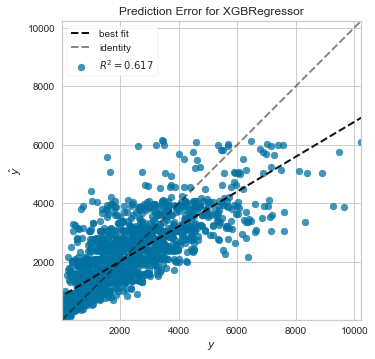

In [48]:
prediction_error(alg,X_train, y_train,X_validation, y_validation)

In [ ]:
y_xg_boost_test = alg.predict(test_df) 

In [49]:
model_params =alg.get_xgb_params() 

In [ ]:
#model_params['max_depth']=4
#model_params['n_estimators']=100


In [50]:
model = xgb.train(
    model_params,
    dtrain,
    num_boost_round=500,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10
)

[0]	Validation-rmse:2445.73
Will train until Validation-rmse hasn't improved in 10 rounds.
[1]	Validation-rmse:2253.09
[2]	Validation-rmse:2082.19
[3]	Validation-rmse:1932.69
[4]	Validation-rmse:1802.56
[5]	Validation-rmse:1688.03
[6]	Validation-rmse:1588.44
[7]	Validation-rmse:1499.86
[8]	Validation-rmse:1424.42
[9]	Validation-rmse:1360.81
[10]	Validation-rmse:1305.5
[11]	Validation-rmse:1257.41
[12]	Validation-rmse:1217.73
[13]	Validation-rmse:1183.21
[14]	Validation-rmse:1158.88
[15]	Validation-rmse:1135.27
[16]	Validation-rmse:1114.46
[17]	Validation-rmse:1098.55
[18]	Validation-rmse:1083.01
[19]	Validation-rmse:1071.57
[20]	Validation-rmse:1061.75
[21]	Validation-rmse:1053.36
[22]	Validation-rmse:1046.28
[23]	Validation-rmse:1040.77
[24]	Validation-rmse:1037.01
[25]	Validation-rmse:1033.65
[26]	Validation-rmse:1030.66
[27]	Validation-rmse:1028.26
[28]	Validation-rmse:1026.49
[29]	Validation-rmse:1025.04
[30]	Validation-rmse:1023.45
[31]	Validation-rmse:1022.45
[32]	Validation-rmse

In [51]:
pred = model.predict(dtest)

In [52]:
#xgb1 =modelfit(alg, X_train,y_train)

In [53]:
submission = pd.DataFrame()
submission['Item_Identifier'] = test_df_copy['Item_Identifier']
submission['Outlet_Identifier'] = test_df_copy['Outlet_Identifier']
submission['Item_Outlet_Sales'] = pred
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="Submission_Regression_XGBoost"+timestamp+"_out.csv"
submission.to_csv(filename,index=False)

In [ ]:
[ col for col in train_df.columns if 'Item_Outlet_Sales' in  col]

In [ ]:
from yellowbrick.model_selection import FeatureImportances

In [ ]:
viz = FeatureImportances(alg,size=(1080, 720))
viz.fit(X, y)
viz.show()